In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir())

# Any results you write to the current directory are saved as output.

['.config', 'sample_data']


In [2]:
from pylab import imread,subplot,imshow,show
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

from keras.preprocessing.image import load_img
from keras.layers import Input, Activation, BatchNormalization, Add, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import seaborn as sns

from sklearn.model_selection import train_test_split
from skimage.transform import resize

import tensorflow as tf

Using TensorFlow backend.


##Copy data from kaggle
kaggle competitions download -c tgs-salt-identification-challenge

In [4]:
# kaggle competitions download -c tgs-salt-identification-challenge
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
%ls

gdrive/  sample_data/


In [5]:
%pwd

'/content'

In [6]:
cd gdrive/My\ Drive/code/py/pro_ii

/content/gdrive/My Drive/code/py/pro_ii


In [7]:
%ls

depths.csv            sample_submission.csv  train/
image-tgs-salt.ipynb  test/                  train.csv


In [8]:
%pwd

'/content/gdrive/My Drive/code/py/pro_ii'

# Load data and analysis

In [0]:
# train - only index
train = pd.read_csv("train.csv", index_col="id", usecols=[0])
depth = pd.read_csv("depths.csv", index_col="id")
# add depth into train
train = train.join(depth)
# all index and depths are not in train
depth_others = depth[~depth.index.isin(train.index)]


In [10]:
# add info of image into train
train["images"] = [np.array(load_img("train/images/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(train.index)]

In [12]:
# add value of mask into train
train["masks"] = [np.array(load_img("train/masks/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(train.index)]

In [0]:
# compute the coverage of image
img_size = 101
train["coverage"] = train.masks.map(np.sum) / (img_size** 2)

In [0]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train["coverage_class"] = train.coverage.map(cov_to_class)

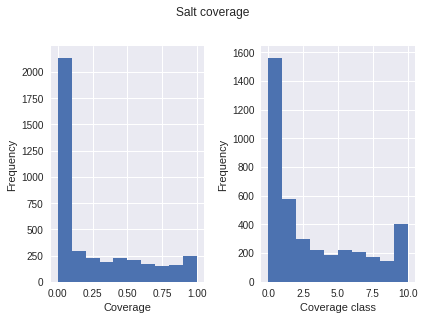

In [15]:
# Salt coverage
plt.subplot(1,2,1)
train.coverage.plot(kind='hist')
plt.xlabel('Coverage')

plt.subplot(1,2,2)
train.coverage_class.plot(kind='hist')
plt.xlabel('Coverage class')

plt.suptitle('Salt coverage',y=1.1)
plt.tight_layout()
plt.show()

Text(0.5,1,'Depth distribution')

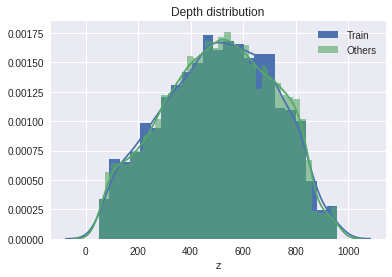

In [16]:
# Depth distributions
sns.distplot(train.z, label="Train",hist_kws=dict(alpha=1))
sns.distplot(depth_others.z, label="Others",hist_kws=dict(alpha=0.6))
plt.legend()
plt.title("Depth distribution")

# Split data

In [0]:
def upsample(img):    
    return resize(img, (img_size, img_size), mode='constant', preserve_range=True)

In [0]:
# train/validation split
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train.index.values,
    np.array(train.images.map(upsample).tolist()).reshape(-1, img_size, img_size, 1), 
    np.array(train.masks.map(upsample).tolist()).reshape(-1, img_size, img_size, 1), 
    train.coverage.values,
    train.z.values,
    test_size=0.3, stratify=train.coverage_class, random_state= 1)

# Model

In [0]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation('relu')(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = Activation('relu')(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [0]:
# Model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = Activation('relu')(convm)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = Activation('relu')(uconv4)
    
    # 12 -> 25    
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = Activation('relu')(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = Activation('relu')(uconv2)
    
    # 50 -> 101    
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = Activation('relu')(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [0]:
#Score the model (from: https://www.kaggle.com/aglotero/another-iou-metric)
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in

    true_objects = 2
    pred_objects = 2

    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in > 0.5 # added by sgx 20180728
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)    
    return np.mean(metric)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float64)
    return metric_value

In [22]:
x_train_1 = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train_1 = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train_1.shape)
print(y_valid.shape)

(5600, 101, 101, 1)
(1200, 101, 101, 1)


In [23]:
# model
input_layer = Input((img_size, img_size, 1))
output_layer = build_model(input_layer, 16, 0.5)

model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[my_iou_metric])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 101, 101, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 16) 64          activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

In [24]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint("./unet_best1.model",monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.2, patience=5, min_lr=0.00001, verbose=1)

epochs = 50
batch_size = 32

history = model.fit(x_train_1, y_train_1,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=2)

Train on 5600 samples, validate on 1200 samples
Epoch 1/50
 - 103s - loss: 0.4424 - my_iou_metric: 0.1268 - val_loss: 0.5371 - val_my_iou_metric: 0.3018

Epoch 00001: val_my_iou_metric improved from -inf to 0.30183, saving model to ./unet_best1.model
Epoch 2/50
 - 88s - loss: 0.2979 - my_iou_metric: 0.2835 - val_loss: 0.4347 - val_my_iou_metric: 0.3943

Epoch 00002: val_my_iou_metric improved from 0.30183 to 0.39425, saving model to ./unet_best1.model
Epoch 3/50
 - 88s - loss: 0.2650 - my_iou_metric: 0.3749 - val_loss: 0.3439 - val_my_iou_metric: 0.3927

Epoch 00003: val_my_iou_metric did not improve from 0.39425
Epoch 4/50
 - 89s - loss: 0.2521 - my_iou_metric: 0.4074 - val_loss: 0.3370 - val_my_iou_metric: 0.5466

Epoch 00004: val_my_iou_metric improved from 0.39425 to 0.54658, saving model to ./unet_best1.model
Epoch 5/50
 - 88s - loss: 0.2343 - my_iou_metric: 0.4471 - val_loss: 0.2588 - val_my_iou_metric: 0.5468

Epoch 00005: val_my_iou_metric improved from 0.54658 to 0.54683, savi

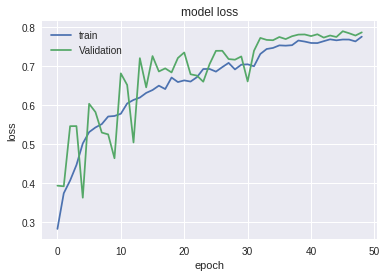

In [25]:
# history for loss
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='best')
plt.show()

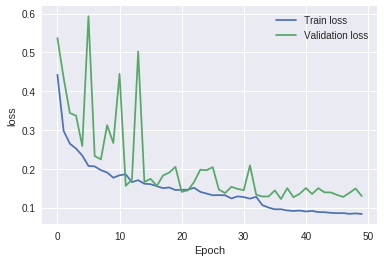

In [26]:
#fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Validation loss")
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

In [0]:
model = load_model("./unet_best1.model",custom_objects={'my_iou_metric': my_iou_metric})

In [0]:
def predict_result(model,x_test,img_size_target): 
    # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict(x_test).reshape(-1, img_size, img_size)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size, img_size)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 + preds_test2)/2
    return preds_avg

In [0]:
def downsample(img):
    return resize(img, (img_size, img_size), mode='constant', preserve_range=True)

preds_valid = predict_result(model,x_valid,img_size)
preds_valid2 = np.array([downsample(x) for x in preds_valid])

y_valid2 = np.array([downsample(x) for x in y_valid])

In [30]:
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_valid2, np.int32(preds_valid2 > threshold)) for threshold in tqdm_notebook(thresholds)])

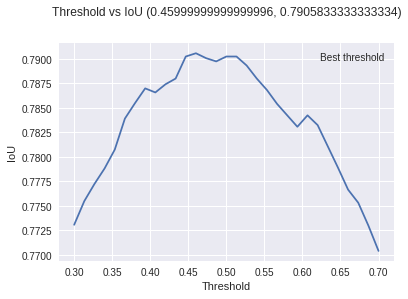

In [31]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best),y=1.1)
plt.legend()

# Test set

In [0]:
def rle_encode(im):
    """
    used for converting the decoded image to rle mask
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [33]:
x_test = np.array([(np.array(load_img("test/images/{}.png".format(idx), color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(depth_others.index)]).reshape(-1, img_size, img_size, 1)

In [0]:
preds_test = predict_result(model,x_test,img_size)

# Output

In [35]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(depth_others.index.values))}

In [0]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_file.csv')

In [37]:
sub

,rle_mask
id,
353e010b7b,
5439dbbddf,
71bab9f311,
52551f7a80,
512d8d9997,813 1 819 1 914 2 920 1 1015 1 1021 1 1116 1 1...
64dba827d6,
0a3a8a5f37,
329563756f,1 4645 4647 100 4748 99 4849 99 4950 98 5051 9...
f6cba2e890,


In [38]:
pred_dict

{'353e010b7b': '',
 '5439dbbddf': '',
 '71bab9f311': '',
 '52551f7a80': '',
 '512d8d9997': '813 1 819 1 914 2 920 1 1015 1 1021 1 1116 1 1120 1 1122 1 1216 3 1221 1 1224 1 1316 4 1321 7 1417 13 1518 17 1618 14 1719 15 1820 16 1921 16 2021 17 2122 18 2223 18 2324 18 2425 19 2526 20 2627 21 2728 21 2829 22 2930 23 3031 23 3132 24 3233 26 3334 27 3435 30 3536 32 3638 35 3741 40 3844 41 3945 43 4047 44 4148 46 4250 47 4352 48 4453 50 4555 50 4657 50 4758 51 4860 51 4961 51 5063 50 5164 50 5266 50 5367 50 5468 49 5570 48 5671 48 5772 47 5874 46 5975 45 6076 45 6177 45 6278 44 6379 44 6480 43 6580 44 6681 43 6782 43 6883 42 6983 42 7084 41 7185 40 7285 41 7386 40 7487 40 7587 41 7688 41 7789 42 7889 43 7990 44 8090 45 8191 46 8292 47 8392 48 8493 48 8593 50 8694 50 8794 51 8895 52 8995 53 9095 54 9195 56 9293 59 9394 60 9495 60 9596 61 9697 62 9798 62 9899 63 10000 63 10101 64',
 '64dba827d6': '',
 '0a3a8a5f37': '',
 '329563756f': '1 4645 4647 100 4748 99 4849 99 4950 98 5051 98 5152 97 5253